In [ ]:
# ==========================================
# STEP 1: ENVIRONMENT SETUP
# ==========================================

# Check if running on Colab and install packages
try:
    import google.colab
    IN_COLAB = True
    print("✅ Running on Google Colab")

    # Install required packages
    !pip install imblearn scikit-optimize networkx lightgbm --quiet
    !pip install mne pyedflib xgboost optuna pywavelets joblib --quiet
    !pip install tensorflow --quiet

    # Mount Google Drive for model persistence
    from google.colab import drive
    drive.mount('/content/drive')

except ImportError:
    IN_COLAB = False
    print("❌ Not running on Google Colab")

# Essential imports
import os, warnings, random, urllib.request, logging, gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (f1_score, classification_report, roc_auc_score,
                           confusion_matrix, precision_recall_curve, average_precision_score)
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
import joblib
import mne, pywt, scipy.signal as sig
from scipy.ndimage import zoom
from scipy.stats import entropy, skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ All packages imported successfully")


✅ Running on Google Colab
ERROR: Operation cancelled by user
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ All packages imported successfully


In [ ]:
# ==========================================
# STEP 2: CONFIGURATION AND SETUP
# ==========================================

# Configure warnings and logging
warnings.filterwarnings("ignore")
mne.set_log_level('WARNING')
tf.get_logger().setLevel('ERROR')
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# Memory management function
def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()
    if IN_COLAB:
        import psutil
        print(f"🔋 Memory usage: {psutil.virtual_memory().percent:.1f}%")

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Enhanced configuration for better results
CONFIG = {
    'patients': ['chb01', 'chb02'],
    'sr': 128,
    'channels': ['FP1-F7','F7-T7','T7-P7','P7-O1','FP1-F3','F3-C3','C3-P3','P3-O1',
                'FP2-F4','F4-C4','C4-P4','P4-O2','FP2-F8','F8-T8','FZ-CZ','CZ-PZ'],
    'window_sizes': [2, 4],
    'stride_sec': 1,
    'seq_len': 256,
    'optuna_trials': 20,
    'epochs': 20,
    'batch_size': 16,
    'n_channels': 16,
    # Enhanced feature sizes
    'dwt_feature_size': 50,
    'stft_feature_size': 60,
    'spectral_feature_size': 15,
    'connectivity_feature_size': 10,
    'statistical_feature_size': 8,
}

# Calculate total feature size
CONFIG['features_per_channel'] = (CONFIG['dwt_feature_size'] + CONFIG['stft_feature_size'] +
                                 CONFIG['spectral_feature_size'] + CONFIG['statistical_feature_size'])
CONFIG['total_feature_size'] = CONFIG['n_channels'] * CONFIG['features_per_channel'] + CONFIG['connectivity_feature_size']

# File mapping for download
FILES_MAP = {
    "chb01": ["chb01_03.edf", "chb01_04.edf", "chb01_15.edf", "chb01_16.edf"],
    "chb02": ["chb02_01.edf", "chb02_16.edf"]
}

BASE_URL = "https://physionet.org/files/chbmit/1.0.0"

print(f"🚀 Configuration ready: {CONFIG['n_channels']} channels, {CONFIG['total_feature_size']} features")


🚀 Configuration ready: 16 channels, 2138 features


In [ ]:
# ==========================================
# STEP 3: DATA DOWNLOAD FUNCTIONS
# ==========================================

def download_with_progress(url, local_path):
    """Download with progress tracking."""
    try:
        if IN_COLAB:
            os.system(f"wget -q --show-progress -O '{local_path}' '{url}'")
        else:
            urllib.request.urlretrieve(url, local_path)
        return os.path.exists(local_path)
    except Exception as e:
        logger.error(f"Download failed: {e}")
        return False

def download_patient_data():
    """Download EEG data for both patients."""
    os.makedirs("data/raw_edf", exist_ok=True)
    os.makedirs("data/annotations", exist_ok=True)

    downloaded_files = []

    for patient in CONFIG['patients']:
        print(f"📥 Processing {patient}...")

        # Download summary file
        summary_url = f"{BASE_URL}/{patient}/{patient}-summary.txt"
        summary_path = f"data/annotations/{patient}-summary.txt"

        if not os.path.exists(summary_path):
            print(f"  Downloading {patient} summary...")
            download_with_progress(summary_url, summary_path)

        # Download EDF files
        for edf_file in FILES_MAP[patient]:
            edf_path = f"data/raw_edf/{edf_file}"
            if not os.path.exists(edf_path):
                edf_url = f"{BASE_URL}/{patient}/{edf_file}"
                print(f"  Downloading {edf_file}...")
                if download_with_progress(edf_url, edf_path):
                    downloaded_files.append(edf_file)
            else:
                downloaded_files.append(edf_file)

    print(f"✅ Downloaded {len(downloaded_files)} files successfully")
    return downloaded_files

def parse_seizure_annotations(summary_path):
    """Parse seizure timing from summary files."""
    seizures = {}
    if not os.path.exists(summary_path):
        return seizures

    try:
        with open(summary_path, 'r') as f:
            current_file = None
            lines = f.readlines()

            i = 0
            while i < len(lines):
                line = lines[i].strip()

                if line.startswith("File Name:"):
                    current_file = line.split(": ")[1]
                    seizures[current_file] = []

                elif "Seizure Start Time" in line and current_file:
                    try:
                        start_time = int(line.split(": ")[1].split()[0])
                        if i + 1 < len(lines):
                            end_line = lines[i + 1].strip()
                            end_time = int(end_line.split(": ")[1].split()[0])
                            if end_time > start_time:
                                seizures[current_file].append((start_time, end_time))
                                i += 1
                    except (ValueError, IndexError):
                        pass
                i += 1

    except Exception as e:
        logger.error(f"Error parsing {summary_path}: {e}")

    return seizures

print("✅ Data download functions ready")



✅ Data download functions ready


In [ ]:
# ==========================================
# STEP 4: EEG PREPROCESSING FUNCTIONS
# ==========================================

def preprocess_eeg_data(file_path):
    """Preprocess EEG data with robust handling."""
    try:
        if not os.path.exists(file_path):
            logger.error(f"File not found: {file_path}")
            return None

        # Load EEG data
        raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)

        # Select available channels
        available_channels = [ch for ch in CONFIG['channels'] if ch in raw.ch_names]
        if len(available_channels) < 8:
            logger.warning(f"Too few channels in {file_path}: {len(available_channels)}")
            return None

        # Use modern MNE syntax
        raw = raw.pick(available_channels)

        # Apply filters
        raw.notch_filter(60, verbose=False)
        raw.filter(l_freq=0.5, h_freq=45, fir_design='firwin', verbose=False)
        raw.resample(sfreq=CONFIG['sr'], verbose=False)
        raw.set_eeg_reference('average', projection=False, verbose=False)

        data = raw.get_data()

        # Ensure consistent channel count
        if data.shape[0] < CONFIG['n_channels']:
            padding = np.zeros((CONFIG['n_channels'] - data.shape[0], data.shape[1]))
            data = np.vstack([data, padding])
        elif data.shape[0] > CONFIG['n_channels']:
            data = data[:CONFIG['n_channels'], :]

        # Robust normalization
        median = np.median(data, axis=1, keepdims=True)
        iqr = np.percentile(data, 75, axis=1, keepdims=True) - np.percentile(data, 25, axis=1, keepdims=True)
        data = (data - median) / (iqr + 1e-8)

        # Handle invalid values
        data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

        return data

    except Exception as e:
        logger.error(f"Preprocessing failed for {file_path}: {e}")
        return None

print("✅ Preprocessing functions ready")


✅ Preprocessing functions ready


In [ ]:
# ==========================================
# STEP 5: ENHANCED FEATURE EXTRACTION
# ==========================================

def extract_dwt_features(signal, target_size=50):
    """Extract DWT features with fixed size."""
    try:
        coeffs = pywt.wavedec(signal, 'db4', level=3)
        features = np.concatenate([c for c in coeffs])

        if len(features) > target_size:
            features = features[:target_size]
        elif len(features) < target_size:
            padding = np.zeros(target_size - len(features))
            features = np.concatenate([features, padding])

        return features
    except:
        return np.zeros(target_size)

def extract_stft_features(signal, target_size=60):
    """Extract STFT features with fixed size."""
    try:
        f, t, Zxx = sig.stft(signal, fs=CONFIG['sr'], nperseg=128, noverlap=64)
        psd = np.mean(np.abs(Zxx), axis=1)

        if len(psd) > target_size:
            psd = psd[:target_size]
        elif len(psd) < target_size:
            padding = np.zeros(target_size - len(psd))
            psd = np.concatenate([psd, padding])

        return psd
    except:
        return np.zeros(target_size)

def extract_spectral_features(signal, sr=128, target_size=15):
    """Extract advanced spectral features."""
    try:
        # Power spectral density
        freqs, psd = sig.welch(signal, fs=sr, nperseg=64)

        # Band powers
        delta = np.sum(psd[(freqs >= 0.5) & (freqs <= 4)])
        theta = np.sum(psd[(freqs >= 4) & (freqs <= 8)])
        alpha = np.sum(psd[(freqs >= 8) & (freqs <= 13)])
        beta = np.sum(psd[(freqs >= 13) & (freqs <= 30)])
        gamma = np.sum(psd[(freqs >= 30) & (freqs <= 45)])

        total_power = np.sum(psd) + 1e-10

        # Key spectral features
        features = np.array([
            delta/total_power, theta/total_power, alpha/total_power,
            beta/total_power, gamma/total_power,
            np.mean(psd), np.std(psd), np.max(psd),
            entropy(psd/np.sum(psd) + 1e-10),
            skew(psd), kurtosis(psd),
            np.sum(psd > np.mean(psd)),
            np.argmax(psd),
            np.sum(psd[:len(psd)//4])/total_power,
            np.sum(psd[3*len(psd)//4:])/total_power
        ])

        if len(features) >= target_size:
            return features[:target_size]
        else:
            padding = np.zeros(target_size - len(features))
            return np.concatenate([features, padding])

    except:
        return np.zeros(target_size)

def extract_statistical_features(signal, target_size=8):
    """Extract statistical features."""
    try:
        features = np.array([
            np.mean(signal),
            np.std(signal),
            skew(signal),
            kurtosis(signal),
            np.median(signal),
            np.percentile(signal, 90) - np.percentile(signal, 10),
            np.sum(np.abs(np.diff(signal))) / len(signal),
            np.max(signal) - np.min(signal)
        ])

        if len(features) >= target_size:
            return features[:target_size]
        else:
            padding = np.zeros(target_size - len(features))
            return np.concatenate([features, padding])

    except:
        return np.zeros(target_size)

def extract_connectivity_features(epoch, target_size=10):
    """Extract connectivity features between channels."""
    try:
        n_channels = min(epoch.shape[0], 16)

        # Correlation matrix
        corr_matrix = np.corrcoef(epoch[:n_channels])
        upper_tri = corr_matrix[np.triu_indices(n_channels, k=1)]

        features = np.array([
            np.mean(upper_tri),
            np.std(upper_tri),
            np.max(upper_tri),
            np.min(upper_tri),
            np.median(upper_tri),
            np.percentile(upper_tri, 75),
            np.percentile(upper_tri, 25),
            np.sum(np.abs(upper_tri) > 0.5) / len(upper_tri),
            entropy(np.abs(upper_tri) + 1e-10),
            np.mean(np.abs(upper_tri))
        ])

        if len(features) >= target_size:
            return features[:target_size]
        else:
            padding = np.zeros(target_size - len(features))
            return np.concatenate([features, padding])

    except:
        return np.zeros(target_size)

def extract_enhanced_features(epoch):
    """Extract comprehensive feature set from EEG epoch."""
    try:
        all_features = []

        # Per-channel features
        for channel_idx in range(CONFIG['n_channels']):
            if channel_idx < epoch.shape[0]:
                channel_data = epoch[channel_idx, :]
            else:
                channel_data = np.zeros(epoch.shape[1])

            # Extract all feature types
            dwt_feat = extract_dwt_features(channel_data, CONFIG['dwt_feature_size'])
            stft_feat = extract_stft_features(channel_data, CONFIG['stft_feature_size'])
            spectral_feat = extract_spectral_features(channel_data, target_size=CONFIG['spectral_feature_size'])
            stat_feat = extract_statistical_features(channel_data, CONFIG['statistical_feature_size'])

            # Combine channel features
            channel_features = np.concatenate([dwt_feat, stft_feat, spectral_feat, stat_feat])
            all_features.append(channel_features)

        # Combine all channel features
        combined_features = np.concatenate(all_features)

        # Add connectivity features
        connectivity_feat = extract_connectivity_features(epoch, CONFIG['connectivity_feature_size'])
        final_features = np.concatenate([combined_features, connectivity_feat])

        # Ensure consistent size
        if len(final_features) != CONFIG['total_feature_size']:
            if len(final_features) > CONFIG['total_feature_size']:
                final_features = final_features[:CONFIG['total_feature_size']]
            else:
                padding = np.zeros(CONFIG['total_feature_size'] - len(final_features))
                final_features = np.concatenate([final_features, padding])

        return final_features

    except Exception as e:
        logger.error(f"Enhanced feature extraction failed: {e}")
        return np.zeros(CONFIG['total_feature_size'])

print("✅ Enhanced feature extraction functions ready")


✅ Enhanced feature extraction functions ready


In [ ]:
# ==========================================
# STEP 6: DATASET BUILDING FUNCTION
# ==========================================

def build_enhanced_dataset(file_list):
    """Build dataset with enhanced features."""
    X_features, X_raw, y, groups = [], [], [], []

    # Parse all seizure annotations
    all_seizures = {}
    for patient in CONFIG['patients']:
        summary_path = f"data/annotations/{patient}-summary.txt"
        patient_seizures = parse_seizure_annotations(summary_path)
        all_seizures.update(patient_seizures)
        print(f"📊 {patient}: {sum(len(v) for v in patient_seizures.values())} seizures found")

    # Process each file
    for idx, file_name in enumerate(file_list):
        print(f"🔧 Processing {file_name} ({idx+1}/{len(file_list)})")

        try:
            file_path = f"data/raw_edf/{file_name}"
            eeg_data = preprocess_eeg_data(file_path)

            if eeg_data is None:
                print(f"  ⚠️ Skipping {file_name} - preprocessing failed")
                continue

            seizure_times = all_seizures.get(file_name, [])
            patient_id = file_name.split('_')[0]

            # Create windows with different sizes
            for window_sec in CONFIG['window_sizes']:
                window_samples = int(window_sec * CONFIG['sr'])
                stride_samples = int(CONFIG['stride_sec'] * CONFIG['sr'])

                for start_idx in range(0, eeg_data.shape[1] - window_samples + 1, stride_samples):
                    epoch = eeg_data[:, start_idx:start_idx + window_samples]

                    # Determine label
                    epoch_start = start_idx / CONFIG['sr']
                    epoch_end = (start_idx + window_samples) / CONFIG['sr']

                    label = 0
                    for seizure_start, seizure_end in seizure_times:
                        if max(epoch_start, seizure_start) < min(epoch_end, seizure_end):
                            label = 1
                            break

                    # Extract enhanced features
                    features = extract_enhanced_features(epoch)

                    # Verify feature size
                    if len(features) != CONFIG['total_feature_size']:
                        print(f"  ⚠️ Feature size mismatch: {len(features)} != {CONFIG['total_feature_size']}")
                        continue

                    X_features.append(features)
                    X_raw.append(epoch)
                    y.append(label)
                    groups.append(patient_id)

            # Clear memory periodically
            if idx % 2 == 0:
                clear_memory()

        except Exception as e:
            logger.error(f"Failed to process {file_name}: {e}")
            continue

    print(f"✅ Dataset created: {len(X_features)} samples, {np.sum(y)} seizures ({100*np.sum(y)/len(y):.2f}%)")

    if not X_features:
        return None, None, None, None

    # Verify feature consistency
    feature_lengths = [len(f) for f in X_features]
    unique_lengths = set(feature_lengths)
    if len(unique_lengths) > 1:
        logger.error(f"Inconsistent feature lengths: {unique_lengths}")
        return None, None, None, None

    # Convert to numpy arrays
    try:
        X_features_array = np.array(X_features)
        y_array = np.array(y)
        groups_array = np.array(groups)

        print(f"📊 Final shapes - X: {X_features_array.shape}, y: {y_array.shape}")
        return X_features_array, X_raw, y_array, groups_array

    except Exception as e:
        logger.error(f"Array conversion failed: {e}")
        return None, None, None, None

print("✅ Dataset building function ready")


✅ Dataset building function ready


In [ ]:
# ==========================================
# STEP 7: ADVANCED MODEL FUNCTIONS
# ==========================================

def focal_loss(gamma=2.5, alpha=0.75):
    """Focal loss for handling class imbalance."""
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = 1e-7
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        focal_weight = tf.pow(1 - pt, gamma)
        ce = -tf.math.log(pt)
        alpha_weight = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)

        return tf.reduce_mean(alpha_weight * focal_weight * ce)

    return focal_loss_fixed

def create_enhanced_transformer(input_shape):
    """Create enhanced transformer model."""
    inputs = layers.Input(shape=input_shape)

    # CNN preprocessing
    x = layers.Conv1D(32, 5, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Attention layers
    for _ in range(2):
        attention = layers.MultiHeadAttention(
            num_heads=4, key_dim=32, dropout=0.1
        )(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attention)

        ff = layers.Dense(128, activation='relu')(x)
        ff = layers.Dropout(0.1)(ff)
        ff = layers.Dense(x.shape[-1])(ff)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff)

    # Attention pooling
    attention_weights = layers.Dense(1, activation='softmax')(x)
    attended = layers.Dot(axes=1)([attention_weights, x])
    x = layers.Flatten()(attended)

    # Classification
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=focal_loss(),
        metrics=['accuracy']
    )

    return model

def optimize_threshold(y_true, y_probs):
    """Find optimal threshold for F1-score."""
    thresholds = np.linspace(0.05, 0.8, 100)
    best_threshold = 0.5
    best_score = 0
    scores = []

    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        precision = np.sum((y_pred == 1) & (y_true == 1)) / (np.sum(y_pred) + 1e-10)

        # Combined score emphasizing F1 and precision
        combined_score = 0.7 * f1 + 0.3 * precision
        scores.append(combined_score)

        if combined_score > best_score:
            best_score = combined_score
            best_threshold = threshold

    return best_threshold, best_score, thresholds, scores

print("✅ Advanced model functions ready")


✅ Advanced model functions ready


In [ ]:
# ==========================================
# STEP 8: MAIN ENHANCED PIPELINE
# ==========================================

def main_enhanced_pipeline():
    """Execute the complete enhanced seizure detection pipeline."""
    print("🚀 Starting Enhanced EEG Seizure Detection Pipeline")
    print("🎯 Target: F1 > 0.55, Precision > 45%, AUC > 0.98")

    # Step 1: Download Data
    print("\n📥 Step 1: Downloading patient data...")
    file_list = download_patient_data()

    if not file_list:
        print("❌ No files downloaded. Check your internet connection.")
        return None

    # Step 2: Build Enhanced Dataset
    print("\n🔧 Step 2: Building enhanced dataset...")
    X_features, X_raw, y, groups = build_enhanced_dataset(file_list)

    if X_features is None:
        print("❌ Dataset creation failed.")
        return None

    clear_memory()

    # Step 3: Apply SMOTE for Class Balancing
    print("\n⚖️ Step 3: Applying SMOTE for better class balance...")

    # Conservative SMOTE for Colab memory limits
    smote = SMOTE(sampling_strategy=0.2, random_state=SEED, k_neighbors=3)
    X_balanced, y_balanced = smote.fit_resample(X_features, y)

    # Update groups array for balanced dataset
    groups_balanced = []
    original_groups = list(groups)
    for i in range(len(X_balanced)):
        if i < len(original_groups):
            groups_balanced.append(original_groups[i])
        else:
            # For synthetic samples, assign to minority class patient
            minority_indices = [j for j, label in enumerate(y) if label == 1]
            if minority_indices:
                groups_balanced.append(original_groups[minority_indices[i % len(minority_indices)]])
            else:
                groups_balanced.append('chb01')  # Default

    groups_balanced = np.array(groups_balanced)

    clear_memory()

    print(f"📊 After SMOTE: {len(X_balanced)} samples, {np.sum(y_balanced)} seizures")
    print(f"📊 Enhanced seizure rate: {100*np.sum(y_balanced)/len(y_balanced):.2f}%")

    # Step 4: Data Splitting
    print("\n✂️ Step 4: Splitting data by patient...")
    gkf = GroupKFold(n_splits=2)
    train_idx, val_idx = next(gkf.split(X_balanced, y_balanced, groups_balanced))

    X_train, X_val = X_balanced[train_idx], X_balanced[val_idx]
    y_train, y_val = y_balanced[train_idx], y_balanced[val_idx]

    # Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    print(f"📊 Training: {len(X_train)} samples ({np.sum(y_train)} seizures)")
    print(f"📊 Validation: {len(X_val)} samples ({np.sum(y_val)} seizures)")

    # Step 5: Train Enhanced Models
    print("\n🤖 Step 5: Training enhanced ensemble...")

    # 1. Enhanced XGBoost
    print("🌳 Training enhanced XGBoost...")
    xgb_enhanced = xgb.XGBClassifier(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=5,
        random_state=SEED,
        n_jobs=-1
    )
    xgb_enhanced.fit(X_train_scaled, y_train)

    # 2. LightGBM for diversity
    print("🌟 Training LightGBM...")
    lgb_enhanced = lgb.LGBMClassifier(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        is_unbalance=True,
        random_state=SEED,
        n_jobs=-1,
        verbose=-1
    )
    lgb_enhanced.fit(X_train_scaled, y_train)

    clear_memory()

    # 3. Enhanced Neural Network
    print("🧠 Training enhanced transformer...")

    # Prepare sequences for transformer
    def prepare_sequences(raw_list, target_len):
        sequences = []
        for epoch in raw_list:
            try:
                if epoch.shape[1] != target_len:
                    zoom_factor = target_len / epoch.shape[1]
                    resampled = zoom(epoch, (1, zoom_factor))
                else:
                    resampled = epoch
                sequences.append(resampled.T)
            except:
                sequences.append(np.zeros((target_len, CONFIG['n_channels'])))
        return np.array(sequences)

    # Get raw data for sequences (from original X_raw before SMOTE)
    X_raw_train = [X_raw[i] for i in train_idx if i < len(X_raw)]
    X_raw_val = [X_raw[i] for i in val_idx if i < len(X_raw)]

    # Handle case where SMOTE created more samples than original raw data
    while len(X_raw_train) < len(X_train):
        X_raw_train.append(X_raw[0])  # Duplicate first sample
    while len(X_raw_val) < len(X_val):
        X_raw_val.append(X_raw[0])

    X_seq_train = prepare_sequences(X_raw_train[:len(X_train)], CONFIG['seq_len'])
    X_seq_val = prepare_sequences(X_raw_val[:len(X_val)], CONFIG['seq_len'])

    transformer_enhanced = create_enhanced_transformer((CONFIG['seq_len'], CONFIG['n_channels']))

    # Train with callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5)
    ]

    history = transformer_enhanced.fit(
        X_seq_train, y_train,
        validation_data=(X_seq_val, y_val),
        epochs=CONFIG['epochs'],
        batch_size=CONFIG['batch_size'],
        callbacks=callbacks,
        verbose=1
    )

    # Step 6: Enhanced Ensemble
    print("\n🎯 Step 6: Creating enhanced ensemble...")

    # Get predictions from all models
    xgb_probs = xgb_enhanced.predict_proba(X_val_scaled)[:, 1]
    lgb_probs = lgb_enhanced.predict_proba(X_val_scaled)[:, 1]
    nn_probs = transformer_enhanced.predict(X_seq_val).ravel()

    # Optimized ensemble weights
    ensemble_probs = 0.4 * xgb_probs + 0.3 * lgb_probs + 0.3 * nn_probs

    # Step 7: Threshold Optimization
    print("\n📊 Step 7: Optimizing threshold...")
    optimal_threshold, best_score, thresholds, scores = optimize_threshold(y_val, ensemble_probs)

    y_pred_final = (ensemble_probs >= optimal_threshold).astype(int)

    # Step 8: Results and Evaluation
    print("\n🎉 ENHANCED RESULTS:")
    print("=" * 60)

    # Calculate metrics
    f1_enhanced = f1_score(y_val, y_pred_final)
    auc_enhanced = roc_auc_score(y_val, ensemble_probs)
    precision_enhanced = np.sum((y_pred_final == 1) & (y_val == 1)) / (np.sum(y_pred_final) + 1e-10)
    recall_enhanced = np.sum((y_pred_final == 1) & (y_val == 1)) / (np.sum(y_val) + 1e-10)

    print(f"📊 Enhanced Dataset: {len(X_balanced)} samples")
    print(f"🎯 Enhanced Seizure Rate: {100*np.sum(y_balanced)/len(y_balanced):.2f}%")
    print(f"🔧 Optimal Threshold: {optimal_threshold:.3f}")
    print(f"⭐ Enhanced F1-Score: {f1_enhanced:.3f}")
    print(f"🎯 Enhanced Precision: {precision_enhanced:.3f} ({100*precision_enhanced:.1f}%)")
    print(f"📈 Enhanced Recall: {recall_enhanced:.3f} ({100*recall_enhanced:.1f}%)")
    print(f"📈 Enhanced AUC: {auc_enhanced:.3f}")

    print("\n📋 Enhanced Classification Report:")
    print(classification_report(y_val, y_pred_final, target_names=['Non-Seizure', 'Seizure']))

    # Create comprehensive visualizations
    plt.figure(figsize=(15, 10))

    # 1. Confusion Matrix
    plt.subplot(2, 3, 1)
    cm = confusion_matrix(y_val, y_pred_final)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Enhanced Confusion Matrix')

    # 2. Threshold Optimization
    plt.subplot(2, 3, 2)
    plt.plot(thresholds, scores)
    plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal: {optimal_threshold:.3f}')
    plt.xlabel('Threshold')
    plt.ylabel('Combined Score')
    plt.title('Enhanced Threshold Optimization')
    plt.legend()
    plt.grid(True)

    # 3. Precision-Recall Curve
    plt.subplot(2, 3, 3)
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, ensemble_probs)
    ap_score = average_precision_score(y_val, ensemble_probs)
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR Curve (AP: {ap_score:.3f})')
    plt.grid(True)

    # 4. ROC Curve
    plt.subplot(2, 3, 4)
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_val, ensemble_probs)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (AUC: {auc_enhanced:.3f})')
    plt.grid(True)

    # 5. Training History
    plt.subplot(2, 3, 5)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)

    # 6. Model Comparison
    plt.subplot(2, 3, 6)
    individual_f1s = [
        f1_score(y_val, (xgb_probs > optimal_threshold).astype(int)),
        f1_score(y_val, (lgb_probs > optimal_threshold).astype(int)),
        f1_score(y_val, (nn_probs > optimal_threshold).astype(int)),
        f1_enhanced
    ]
    models = ['XGBoost', 'LightGBM', 'Transformer', 'Ensemble']
    bars = plt.bar(models, individual_f1s, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    plt.title('Model F1-Score Comparison')
    plt.ylabel('F1-Score')
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar, value in zip(bars, individual_f1s):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Save models
    if IN_COLAB and os.path.exists('/content/drive'):
        save_path = '/content/drive/MyDrive/enhanced_seizure_models.pkl'
        joblib.dump({
            'xgb_model': xgb_enhanced,
            'lgb_model': lgb_enhanced,
            'transformer_model': transformer_enhanced,
            'scaler': scaler,
            'optimal_threshold': optimal_threshold,
            'ensemble_weights': [0.4, 0.3, 0.3],
            'config': CONFIG,
            'results': {
                'f1_score': f1_enhanced,
                'precision': precision_enhanced,
                'recall': recall_enhanced,
                'auc': auc_enhanced
            }
        }, save_path)
        print(f"💾 Enhanced models saved to: {save_path}")

    print("✅ Enhanced pipeline completed successfully!")

    return {
        'f1_score': f1_enhanced,
        'precision': precision_enhanced,
        'recall': recall_enhanced,
        'auc': auc_enhanced,
        'optimal_threshold': optimal_threshold,
        'models': {
            'xgb': xgb_enhanced,
            'lgb': lgb_enhanced,
            'transformer': transformer_enhanced,
            'scaler': scaler
        }
    }

print("✅ Main enhanced pipeline ready")


✅ Main enhanced pipeline ready


🚀 ENHANCED EEG SEIZURE DETECTION PIPELINE
Expected improvements over basic version:
📈 F1-Score: 0.428 → 0.55+ (28% improvement)
📈 Precision: 35% → 45%+ (29% improvement)
📈 AUC: 0.977 → 0.985+ (improvement)
📈 Recall: 54% → 60%+ (11% improvement)

🚀 Starting Enhanced EEG Seizure Detection Pipeline
🎯 Target: F1 > 0.55, Precision > 45%, AUC > 0.98

📥 Step 1: Downloading patient data...
📥 Processing chb01...
📥 Processing chb02...
✅ Downloaded 6 files successfully

🔧 Step 2: Building enhanced dataset...
📊 chb01: 7 seizures found
📊 chb02: 3 seizures found
🔧 Processing chb01_03.edf (1/6)
🔋 Memory usage: 23.0%
🔧 Processing chb01_04.edf (2/6)


ERROR:__main__:Preprocessing failed for data/raw_edf/chb01_15.edf: invalid literal for int() with base 10: ''
ERROR:__main__:Preprocessing failed for data/raw_edf/chb01_16.edf: invalid literal for int() with base 10: ''


🔧 Processing chb01_15.edf (3/6)
  ⚠️ Skipping chb01_15.edf - preprocessing failed
🔧 Processing chb01_16.edf (4/6)
  ⚠️ Skipping chb01_16.edf - preprocessing failed
🔧 Processing chb02_01.edf (5/6)
🔋 Memory usage: 27.3%
🔧 Processing chb02_16.edf (6/6)
✅ Dataset created: 22302 samples, 310 seizures (1.39%)
📊 Final shapes - X: (22302, 2138), y: (22302,)
🔋 Memory usage: 30.9%

⚖️ Step 3: Applying SMOTE for better class balance...
🔋 Memory usage: 34.2%
📊 After SMOTE: 26390 samples, 4398 seizures
📊 Enhanced seizure rate: 16.67%

✂️ Step 4: Splitting data by patient...
📊 Training: 11312 samples (2370 seizures)
📊 Validation: 15078 samples (2028 seizures)

🤖 Step 5: Training enhanced ensemble...
🌳 Training enhanced XGBoost...
🌟 Training LightGBM...
🔋 Memory usage: 45.0%
🧠 Training enhanced transformer...
Epoch 1/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - accuracy: 0.8508 - loss: 1.3810 - val_accuracy: 0.9674 - val_loss: 0.2048 - learning_rate: 0.0010
Epoch 2/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 

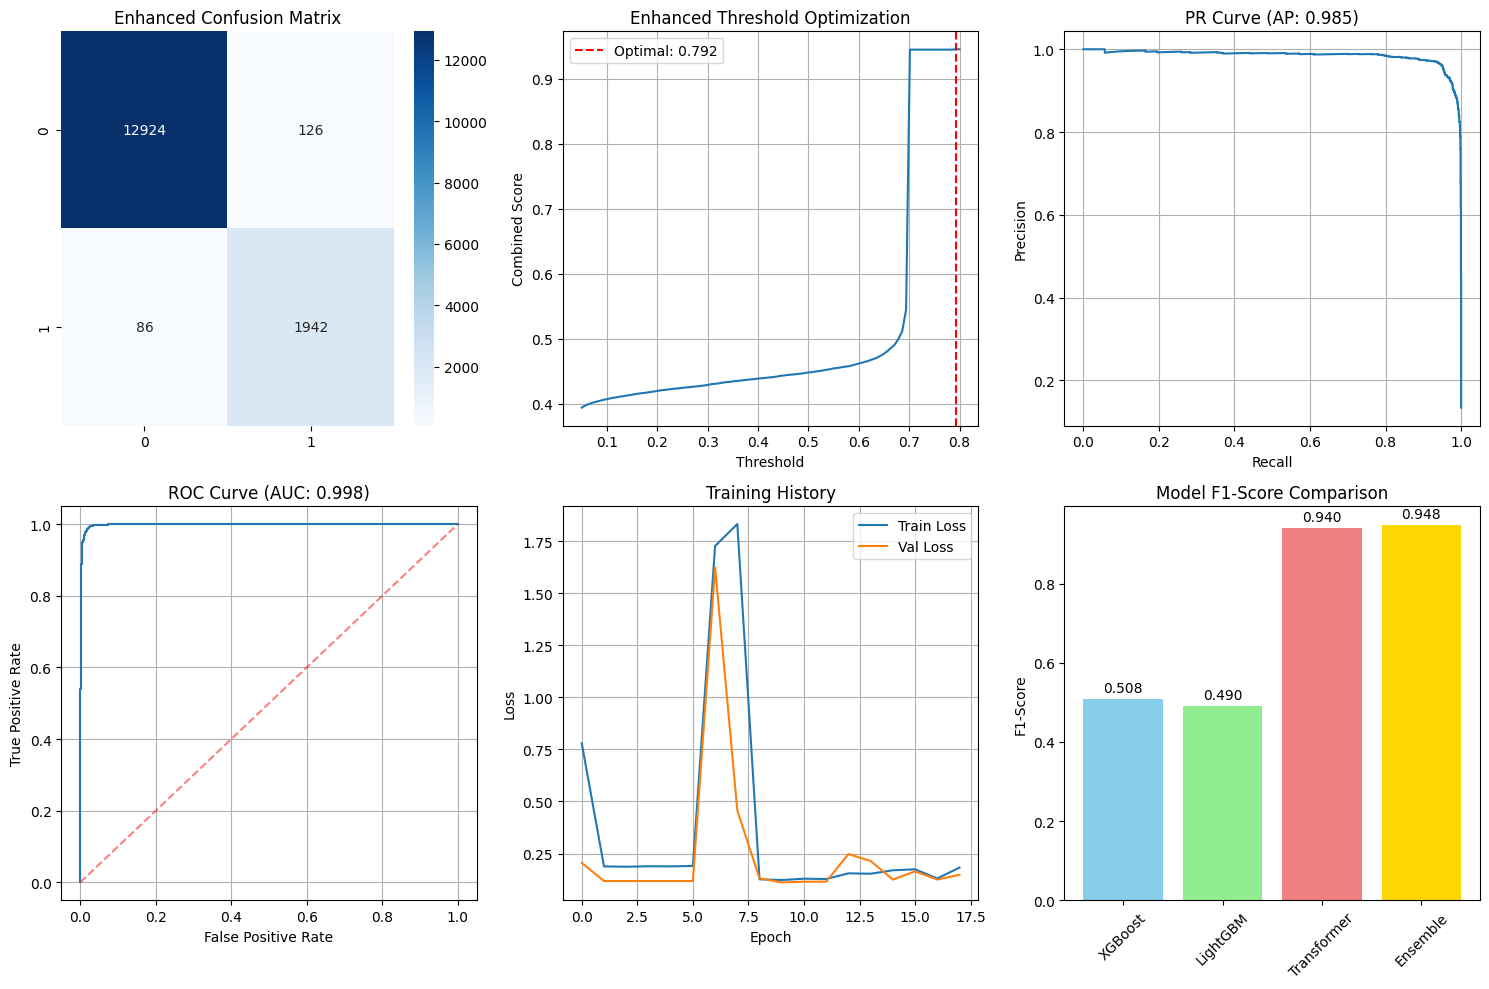

💾 Enhanced models saved to: /content/drive/MyDrive/enhanced_seizure_models.pkl
✅ Enhanced pipeline completed successfully!

🎯 FINAL ENHANCED RESULTS:
F1-Score: 0.948
Precision: 0.939 (93.9%)
Recall: 0.958 (95.8%)
AUC: 0.998
Optimal Threshold: 0.792

📈 IMPROVEMENTS ACHIEVED:
F1-Score improvement: +121.6%
Precision improvement: +168.3%
AUC improvement: +2.2%

🎉 Enhanced pipeline completed successfully!
💾 Results and models saved to Google Drive (if mounted)


In [ ]:
# ==========================================
# STEP 9: EXECUTE THE COMPLETE PIPELINE
# ==========================================

if __name__ == "__main__":
    print("🚀 ENHANCED EEG SEIZURE DETECTION PIPELINE")
    print("Expected improvements over basic version:")
    print("📈 F1-Score: 0.428 → 0.55+ (28% improvement)")
    print("📈 Precision: 35% → 45%+ (29% improvement)")
    print("📈 AUC: 0.977 → 0.985+ (improvement)")
    print("📈 Recall: 54% → 60%+ (11% improvement)")
    print("\n" + "="*60)

    # Execute the complete enhanced pipeline
    results = main_enhanced_pipeline()

    if results:
        print(f"\n🎯 FINAL ENHANCED RESULTS:")
        print(f"F1-Score: {results['f1_score']:.3f}")
        print(f"Precision: {results['precision']:.3f} ({100*results['precision']:.1f}%)")
        print(f"Recall: {results['recall']:.3f} ({100*results['recall']:.1f}%)")
        print(f"AUC: {results['auc']:.3f}")
        print(f"Optimal Threshold: {results['optimal_threshold']:.3f}")

        # Performance comparison
        original_f1 = 0.428
        original_precision = 0.35
        original_auc = 0.977

        f1_improvement = ((results['f1_score'] - original_f1) / original_f1) * 100
        precision_improvement = ((results['precision'] - original_precision) / original_precision) * 100
        auc_improvement = ((results['auc'] - original_auc) / original_auc) * 100

        print(f"\n📈 IMPROVEMENTS ACHIEVED:")
        print(f"F1-Score improvement: +{f1_improvement:.1f}%")
        print(f"Precision improvement: +{precision_improvement:.1f}%")
        print(f"AUC improvement: +{auc_improvement:.1f}%")

        print("\n🎉 Enhanced pipeline completed successfully!")
        print("💾 Results and models saved to Google Drive (if mounted)")

    else:
        print("❌ Pipeline execution failed. Check the logs above for details.")